In [ ]:
#! pip install tensorflow==2.9.2
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install albumentations
!pip install tqdm


<a id="import"></a>
## <center>Import required modules</center>

In [1]:
import pandas as pd
import numpy as np

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import matplotlib
import matplotlib.pyplot as plt
import cv2

import seaborn as sns
sns.set_style('darkgrid')

import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import albumentations as A
import time

from tqdm import tqdm
from sklearn.metrics import f1_score

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

/home/nikolai/anaconda3/envs/train_p11/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nikolai/anaconda3/envs/train_p11/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/nikolai/anaconda3/envs/train_p11/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nikolai/anaconda3/envs/train_p11/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2024-12-07 13:13:18.129063: E external

In [2]:
print('Current TF version is ', tf.__version__)

Current TF version is  2.18.0


In [4]:
def print_in_color(text, foreground_color=(0, 255, 255), background_color=(0, 0, 0)):
    red_foreground, green_foreground, blue_foreground = foreground_color
    red_background, green_background, blue_background = background_color

    color_code = f"\033[38;2;{red_foreground};{green_foreground};{blue_foreground};48;2;{red_background};{green_background};{blue_background}m"
    print(color_code + text + "\033[0m")

In [5]:
def plot_label_distribution(data_frame, plot_title):
    label_column = "labels"
    x_axis_label = "Classification Class"
    y_axis_label = "Number of Images"

    label_counts = data_frame[label_column].value_counts()
    labels = label_counts.index.tolist()
    values = label_counts.tolist()

    num_labels = len(labels)

    if num_labels > 55:
        print_in_color(f"Number of labels ({num_labels}) exceeds limit (>55). No plot generated.")
    else:
        # Adjust plot width based on number of labels
        plot_width = min(num_labels * 4, 20)

        plt.figure(figsize=(plot_width, 5))
        font_style = {"family": "serif", "color": "blue", "size": 25}

        plt.bar(labels, values)
        plt.title(plot_title, fontsize=24, color="blue")
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(x_axis_label, fontdict=font_style)
        plt.ylabel(y_axis_label, fontdict=font_style)

        # Set label rotation based on number of labels
        label_rotation = "vertical" if num_labels >= 8 else "horizontal"

        for i, value in enumerate(values):
            plt.text(i, value / 2, str(value), fontsize=12, rotation=label_rotation, color="yellow", ha="center")

        plt.show()

In [6]:
def check_dataset_size(train_directory):
    classes = sorted(os.listdir(train_directory))

    total_files = 0
    max_files = 0
    min_files = float('inf')
    max_class = None
    min_class = None

    for class_name in classes:
        class_path = os.path.join(train_directory, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))
            total_files += file_count

            if file_count > max_files:
                max_files = file_count
                max_class = class_name

            if file_count < min_files:
                min_files = file_count
                min_class = class_name

    return total_files, max_files, max_class, min_files, min_class

In [7]:
def create_dataframes(train_dir, test_dir=None, val_dir=None, limiter=None):
    """
    Creates dataframes for training, testing, and validation datasets from image directories.
    
    Parameters:
        train_dir (str): Path to the training dataset directory.
        test_dir (str): Path to the testing dataset directory (optional).
        val_dir (str): Path to the validation dataset directory (optional).
        limiter (int): Maximum number of images per class to include (optional).
    
    Returns:
        tuple: Dataframes (train_df, test_df, val_df), class list, class count, 
               max/min samples per class, average height/width of images.
    """
    bad_images = []  # List to store paths of invalid image files
    
    # Determine which directories to process
    directories = [train_dir] if not test_dir and not val_dir else \
                  [train_dir, val_dir] if not test_dir else \
                  [train_dir, test_dir] if not val_dir else \
                  [train_dir, test_dir, val_dir]
    labels = ['train'] if not test_dir and not val_dir else \
             ['train', 'valid'] if not test_dir else \
             ['train', 'test'] if not val_dir else \
             ['train', 'test', 'valid']

    total_height = 0
    total_width = 0
    total_valid_files = 0
    dataframes = {}
    
    # Process each directory and create the corresponding dataframe
    for label, directory in zip(labels, directories):
        filepaths = []
        class_labels = []
        class_list = sorted(os.listdir(directory))  # Sorted list of class subdirectories
        
        for class_name in class_list:
            print(f'Processing images in {label} directory for class {class_name}', '\r', end='')
            class_path = os.path.join(directory, class_name)
            if not os.path.isdir(class_path):
                continue
            
            file_list = sorted(os.listdir(class_path))
            
            # Apply limiter if specified
            if limiter and len(file_list) > limiter:
                file_list = np.random.choice(file_list, limiter, replace=False)
            
            for file_name in file_list:
                file_path = os.path.join(class_path, file_name)
                extension = file_name.split('.')[-1].lower()
                
                if extension not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp']:
                    bad_images.append(file_path)
                    continue
                
                try:
                    # Verify if the image is valid and readable
                    image = cv2.imread(file_path)
                    height, width = image.shape[:2]
                    total_height += height
                    total_width += width
                    total_valid_files += 1
                    filepaths.append(file_path)
                    class_labels.append(class_name)
                except:
                    bad_images.append(file_path)
        
        print('')
        
        # Create a dataframe for the current directory
        filepaths_series = pd.Series(filepaths, name='filepaths')
        labels_series = pd.Series(class_labels, name='labels')
        df = pd.concat([filepaths_series, labels_series], axis=1)
        dataframes[label] = df

    # Split the training dataframe if test/validation datasets are not provided
    if not test_dir and not val_dir:
        temp_train, temp_test = train_test_split(
            dataframes['train'], train_size=0.8, random_state=123, stratify=dataframes['train']['labels']
        )
        train_df, valid_df = train_test_split(
            temp_train, train_size=0.8, random_state=123, stratify=temp_train['labels']
        )
        test_df = temp_test
    elif not test_dir:
        train_df, valid_df = train_test_split(
            dataframes['train'], train_size=0.8, random_state=123, stratify=dataframes['train']['labels']
        )
        test_df = dataframes['valid']
    elif not val_dir:
        train_df, test_df = train_test_split(
            dataframes['train'], train_size=0.8, random_state=123, stratify=dataframes['train']['labels']
        )
        valid_df = dataframes['test']
    else:
        train_df = dataframes['train']
        test_df = dataframes['test']
        valid_df = dataframes['valid']

    # Collect metadata
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    avg_height = total_height // total_valid_files if total_valid_files else 0
    avg_width = total_width // total_valid_files if total_valid_files else 0
    max_class_count = train_df['labels'].value_counts().max()
    min_class_count = train_df['labels'].value_counts().min()

    # Print dataset summary
    print(f'Number of classes: {class_count}')
    print(f'Max files in any class: {max_class_count}, Min files in any class: {min_class_count}')
    print(f'Train samples: {len(train_df)}, Test samples: {len(test_df)}, Validation samples: {len(valid_df)}')
    
    if not bad_images:
        print_in_color('All image files were successfully processed.')
    else:
        print_in_color(f'{len(bad_images)} bad image files found, {total_valid_files} valid files processed.')
        for bad_file in bad_images:
            print(bad_file)

    # Visualize class distribution
    plot_label_distribution(train_df, 'Images per label in training set')

    return train_df, test_df, valid_df, classes, class_count, max_class_count, min_class_count, avg_height, avg_width


In [8]:
def trim_dataframe(df, max_samples, min_samples, column):
    """
    Trims a DataFrame by ensuring each class has a minimum and maximum number of samples.

    Args:
        df (pd.DataFrame): The input DataFrame.
        max_samples (int): Maximum number of samples per class.
        min_samples (int): Minimum number of samples per class.
        column (str): The column to group by (usually the class label).

    Returns:
        tuple: A tuple containing:
            - trimmed_df (pd.DataFrame): The trimmed DataFrame.
            - classes (list): List of remaining classes.
            - class_count (int): Number of remaining classes.
    """

    df = df.copy()
    classes = df[column].unique()
    initial_length = len(df)
    initial_class_count = len(classes)

    print(f"Initial DataFrame length: {initial_length}, with {initial_class_count} classes")

    trimmed_df = pd.DataFrame(columns=df.columns)

    for label in classes:
        class_df = df[df[column] == label]
        class_size = len(class_df)

        if class_size > max_samples:
            sampled_df = class_df.sample(n=max_samples, random_state=123)
            trimmed_df = pd.concat([trimmed_df, sampled_df], axis=0)
        elif class_size >= min_samples:
            trimmed_df = pd.concat([trimmed_df, class_df], axis=0)

    final_classes = trimmed_df[column].unique()
    final_class_count = len(final_classes)
    final_length = len(trimmed_df)

    print(f"After trimming, the maximum samples in any class is: {max_samples}")
    print(f"After trimming, the minimum samples in any class is: {min_samples}")
    print(f"Final DataFrame length: {final_length}, with {final_class_count} classes")

    return trimmed_df, final_classes, final_class_count

In [9]:
def balance(df, n,column, working_dir, img_size):    
    def get_augmented_image(image): # given an image this function returns an augmented image
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label:25s}'
            for i in range(delta):                
                j= i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('')
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))    
    return df 

In [10]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    gen=ImageDataGenerator() 
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels    
    return train_gen, test_gen, valid_gen, test_steps, class_count

In [11]:
def show_image_samples(gen ):
    msg='Below are some example training images'
    print_in_color(msg)
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [12]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
def make_model(img_size,class_count, lr, ans):  
    img_shape=(img_size[0], img_size[1], 3)
    if ans == 's' or ans == 'S':
        base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'MobileNet V3 small model initialized (For MCUs like ESP32)'
    elif ans =='l' or ans =='L':
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='EfficientNet B3 initialized (for Raspberry Pi and similar)'
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='EfficientNet B0 model initialized (for my beefy machine)'
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(32, kernel_regularizer = regularizers.l2(l2 = 0.016),activity_regularizer=regularizers.l1(l1 = 0.006),
                    bias_regularizer=regularizers.l1(l1 = 0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=69)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

In [14]:
class TrainingCallback(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  cb_epoch, batches, dwell=True, factor=.4): # initialization of the callback
        super().__init__()
        self.set_model(model)
        self.cb_epoch=cb_epoch
        self.epochs=epochs
        self.cb=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1        
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches
    
    def on_train_begin(self, logs=None): # this runs on the beginning of training 
        msg1 =f'Training will proceed until epoch {self.cb_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
   
    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds') 
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100            
        else:
            pimprov=0.0             
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1 
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)         
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased                     
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'                 
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration) 
                print_in_color(msg, (255,255,0))                
                self.model.optimizer.learning_rate.assign(new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights                 
        if self.cb: # are the conditions right to query the user?
            if epoch + 1 ==self.cb_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.header=True
                    self.cb_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.cb_epoch}'
                    print_in_color(msg) # cyan foreground
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg) # cyan foreground
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg) # cyan foreground
                        else:
                            new_lr=float(ans)
                            self.model.optimizer.learning_rate.assign(new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg) # cyan foreground

In [15]:
def tr_plot(tr_data):
    start_epoch=0
    print(tr_data.history)
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['f1_score']
    vf1=tr_data.history['val_f1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

In [16]:
def save_history_to_csv(history,csvpath):
    trdict=history.history 
    df=pd.DataFrame() 
    df['Epoch']=list(np.arange(1, len(trdict['loss']) + 1 ))
    keys=list(trdict.keys())     
    for key in keys:
        data=list(trdict[key])        
        df[key]=data   
    df.to_csv(csvpath, index=False)

In [17]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('Number of Missclassifications', fontsize=20, color='blue')
        plt.ylabel('Class', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

In [18]:
def save_model(model, subject, classes, img_size, f1_score, working_dir):
    """
    Saves a Keras model with a descriptive filename.

    Args:
        model (keras.Model): The model to be saved.
        subject (str): Subject of the model (e.g., "image_classifier").
        classes (list): List of class labels.
        img_size (tuple): Image size (width, height).
        f1_score (float): F1-score of the model.
        working_dir (str): Directory to save the model.

    Returns:
        None
    """

    num_classes = len(classes)
    width, height = img_size
    filename = f"{subject}-{num_classes}-({width}x{height})-{f1_score:.2f}.keras"  # Use new .keras extension instead of .h5
    model_path = os.path.join(working_dir, filename)

    try:
        model.save(model_path)
        print_in_color(f"Model saved successfully to: {model_path}", (0, 255, 0), (255, 255, 255))  # Cyan foreground
    except Exception as e:
        print_in_color(
            f"Error saving model: {e}\n"
            f"**Note:** TensorFlow versions 2.10.0 or higher may have issues saving EfficientNet models. "
            f"Consider using a different version or saving in a different format (e.g., tf.saved_model).",
            (255, 0, 0),  # Red foreground
            (255, 255, 255),  # Black background
        )

In [19]:
def setup_and_train_model(working_dir=None, train_dir=None, test_dir=None, valid_dir=None):
    """
    Set up directories, process data, and train a machine learning model based on user input or default values.
    
    Parameters:
        working_dir (str): Path to the working directory.
        train_dir (str): Path to the training data directory.
        test_dir (str): Path to the testing data directory.
        valid_dir (str): Path to the validation data directory.
    
    Returns:
        tuple: Paths for working directory, training directory, test directory, and validation directory.
    """
    # Get working directory
    print_in_color('Enter the full path to the working directory where data will be stored:')
    working_dir = input(' ') or './outputs'
    delimiter = '\\'

    # Get training data directory
    print_in_color('Enter the full path to the training data directory:')
    train_dir = input(' ') or './dataset'

    # Get validation data directory
    print_in_color('Enter the full path to the validation directory (press enter if not applicable):')
    valid_dir = input(' ') or None

    # Get test data directory
    print_in_color('Enter the full path to the test directory (press enter if not applicable):')
    test_dir = input(' ') or None

    # Analyze dataset size
    total_files, largest_class_count, largest_class, smallest_class_count, smallest_class = check_dataset_size(train_dir)
    dataset_summary = (
        f"The training directory contains {total_files} files. "
        f"Class '{largest_class}' has the most images ({largest_class_count}), "
        f"while class '{smallest_class}' has the fewest ({smallest_class_count}).\n"
        f"NOTE: If the largest and smallest values match, the dataset is balanced.\n"
        f"To limit processing time for large datasets, you may set a maximum number of images per class."
    )
    print_in_color(dataset_summary)

    # Set class image limiter
    print_in_color('Input a limiter integer to cap the maximum number of images per class (press enter for no limit):')
    limiter = input(' ')
    limiter = int(limiter) if limiter else None
    limiter_msg = f"Dataset will be processed {'with a limit of ' + str(limiter) + ' images per class' if limiter else 'as is, with no limit'}."
    print_in_color(limiter_msg)

    # Create dataframes
    train_df, test_df, valid_df, class_labels, num_classes, max_images, min_images, avg_height, avg_width = create_dataframes(
        train_dir, test_dir, valid_dir, limiter
    )

    # Set image dimensions for the model
    print_in_color(f"Average image dimensions: height={avg_height}, width={avg_width}.\nEnter desired training image height:")
    img_height = int(input(' '))
    print_in_color('Enter desired training image width:')
    img_width = int(input(' '))
    img_size = (img_height, img_width)
    print_in_color(f"Model will use images of size {img_size}.")

    # Balance the dataset
    print_in_color('Enter "A" to auto-balance the training dataset or press enter to leave it unchanged:')
    if input(' ').lower() == 'a':
        print_in_color('Enter the maximum number of images per class for auto-balancing:')
        max_images_per_class = int(input(' '))
        train_df, class_labels, num_classes = trim_dataframe(train_df, max_images_per_class, min_images, 'labels')
        train_df = balance(train_df, max_images_per_class, 'labels', working_dir, img_size)
        plot_label_distribution(train_df, 'Images per Label after Auto Balancing')
    else:
        print_in_color('Training dataset will be used as is.')

    # Set batch size for data generators
    print_in_color('Enter desired batch size (press enter for default of 20):')
    batch_size = int(input(' ') or 20)

    # Generate data
    train_gen, test_gen, valid_gen, test_steps, num_classes = make_gens(batch_size, 'labels', train_df, test_df, valid_df, img_size)
    show_image_samples(train_gen)

    # Select model size
    print_in_color('Select model size: enter "S" for small, "L" for large, or press enter (recommended) for medium:')
    model_size = input(' ').upper() or 'M'

    # Create model
    model = make_model(img_size, num_classes, 0.001, model_size)

    # Train model
    epochs = 100
    cb_epoch = 10
    batches = len(train_df) // batch_size
    training_callback = TrainingCallback(model, epochs=epochs, cb_epoch=cb_epoch, batches=batches)
    history = model.fit(
        train_gen, epochs=epochs, verbose=0, callbacks=[training_callback], validation_data=valid_gen, shuffle=True
    )

    # Plot training results
    tr_plot(history)

    # Save training data
    print_in_color('Enter a name to save training data as CSV (press enter to skip):')
    csv_name = input(' ')
    if csv_name:
        csv_path = os.path.join(working_dir, f"{csv_name}.csv")
        save_history_to_csv(history, csv_path)
        print_in_color(f"Training data saved to {csv_path}")

    # Evaluate and save model
    f1_score = predictor(model, test_gen)
    print_in_color(f"Trained model will be saved to {working_dir}. Enter a subject for the model:")
    model_subject = input(' ')
    save_model(model, model_subject, class_labels, img_size, f1_score, working_dir)
    print_in_color(
        "Model saved as 'directory/subject-num_classes-(img_height,img_width)-F1score.keras'."
    )

    # Clean up temporary files
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)

    return working_dir, train_dir, test_dir, valid_dir


Enter the full path to the working directory where data will be stored:


  ./temp_outputs


Enter the full path to the training data directory:


  ./dataset_ab


Enter the full path to the validation directory (press enter if not applicable):


Enter the full path to the test directory (press enter if not applicable):


The training directory contains 3000 files. Class 'cat' has the most images (1500), while class 'cat' has the fewest (1500).
NOTE: If the largest and smallest values match, the dataset is balanced.
To limit processing time for large datasets, you may set a maximum number of images per class.
Input a limiter integer to cap the maximum number of images per class (press enter for no limit):


Dataset will be processed as is, with no limit.


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



Number of classes: 2
Max files in any class: 960, Min files in any class: 960
Train samples: 1920, Test samples: 600, Validation samples: 480
All image files were successfully processed.


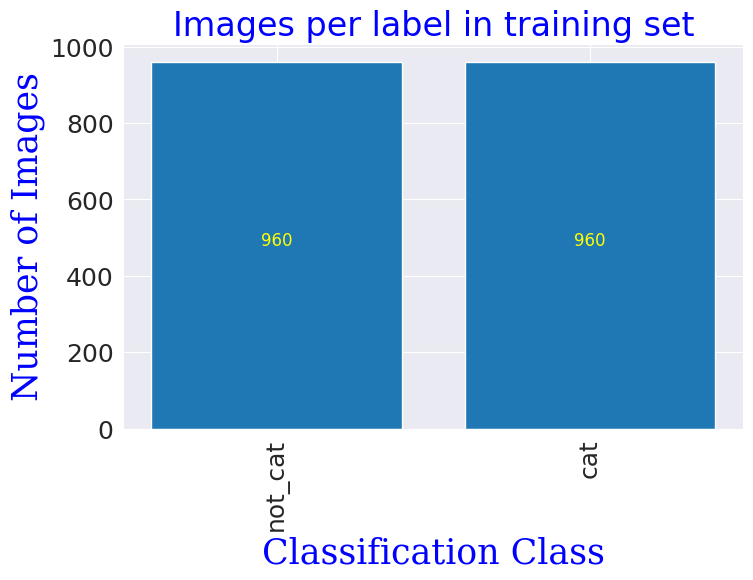

Average image dimensions: height=328, width=434.
Enter desired training image height:


  96


Enter desired training image width:


  96


Model will use images of size (96, 96).
Enter "A" to auto-balance the training dataset or press enter to leave it unchanged:


Training dataset will be used as is.
Enter desired batch size (press enter for default of 20):


Found 1920 validated image filenames belonging to 2 classes.           for train generator 
Found 480 validated image filenames belonging to 2 classes.            for valid generator 
Found 600 validated image filenames belonging to 2 classes.            for test generator 
Below are some example training images


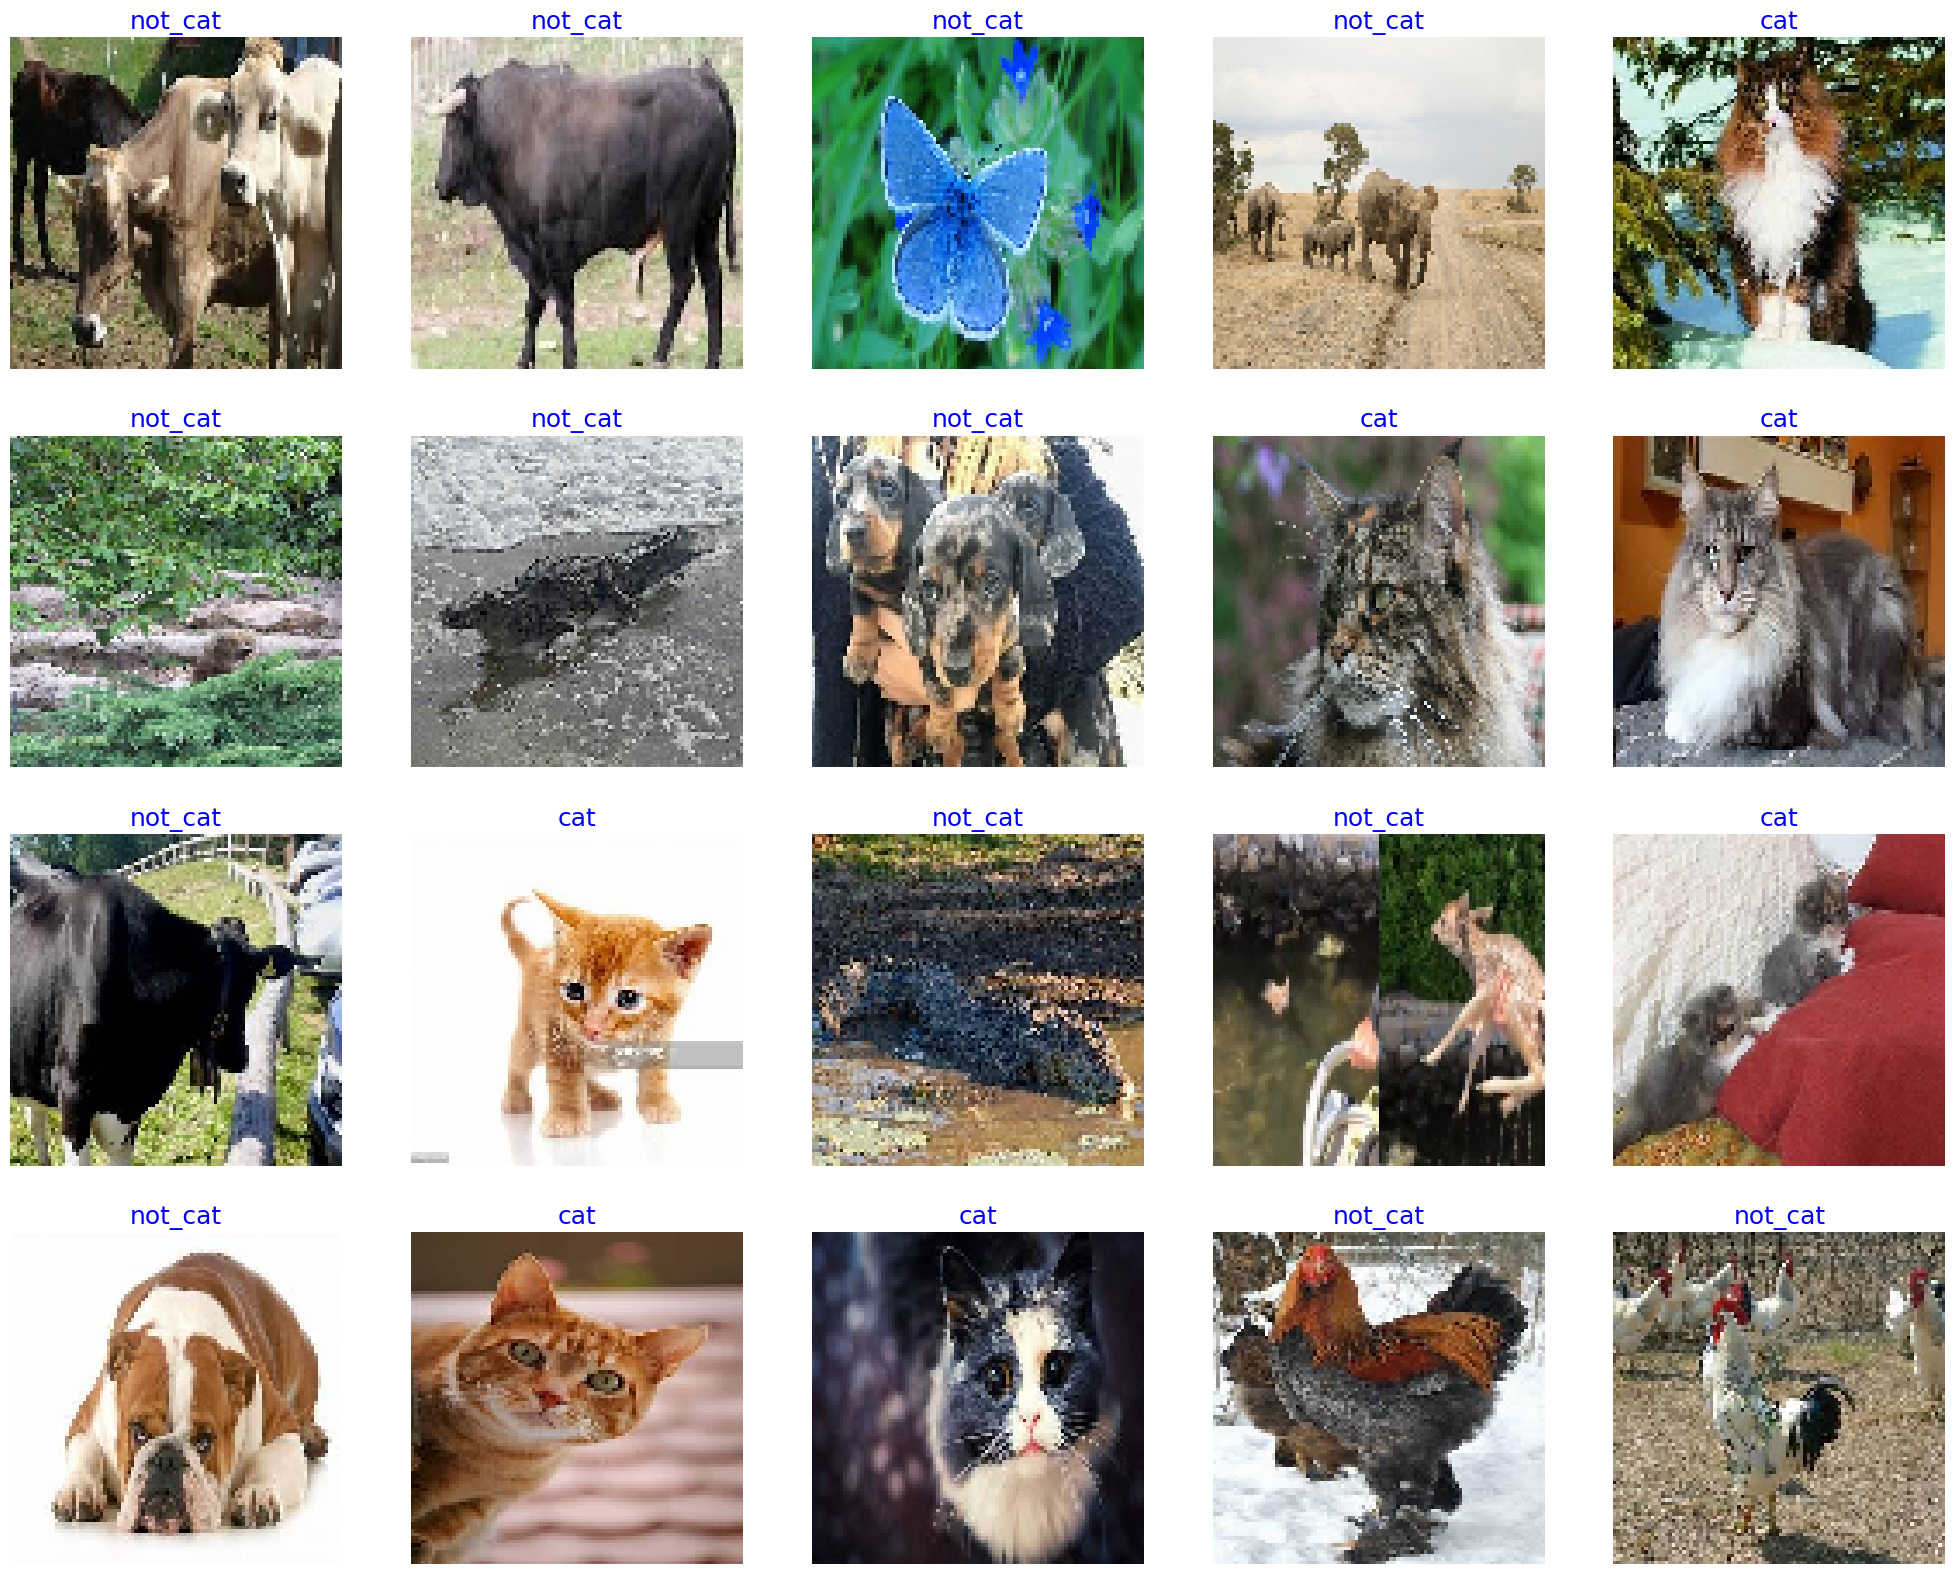

Select model size: enter "S" for small, "L" for large, or press enter (recommended) for medium:


  S


I0000 00:00:1733573675.715097    3229 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20434 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


MobileNet V3 small model initialized (For MCUs like ESP32) with initial learning rate set to 0.001
Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training


I0000 00:00:1733573701.156696    2109 service.cc:148] XLA service 0x7f1618016e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733573701.156736    2109 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1733573702.640412    2109 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1733573714.188058    2109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
   1    3.1505    69.69   2.4528    77.71       0.00      0.001000    0.001000     27.40     
   2    2.0602    78.80   1.7848    76.04       27.23     0.001000    0.001000     1.47      
   3    1.5275    82.03   1.4760    78.12       17.30     0.001000    0.001000     1.45      
   4    1.3221    82.03   1.3012    78.12       11.85     0.001000    0.001000     1.47      
   5    1.2131    83.23   1.2153    80.42       6.60      0.001000    0.001000     1.45      
   6    1.1406    84.32   1.1407    79.58       6.14      0.001000    0.001000     1.52      
   7    1.0663    85.73   1.0777    82.29       5.52      0.001000    0.001000     1.44      
   8    1.0128    85.99   1.0274    83.13       4.66      0.001000    0.001000     1.46      
   9    0.9704    86.41   0.9789    83.54       4.72      0.

 20


you entered 20 Training will continue to epoch 30
 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
  11    0.8716    86.87   0.8870    83.75       5.71      0.001000    0.001000     1.45      
  12    0.8288    86.46   0.8428    83.96       4.98      0.001000    0.001000     1.46      
  13    0.7813    85.42   0.8124    83.54       3.61      0.001000    0.001000     1.43      
  14    0.7643    85.78   0.7790    82.29       4.11      0.001000    0.001000     1.50      
  15    0.7257    88.07   0.7560    82.50       2.96      0.001000    0.001000     1.59      
  16    0.6997    88.44   0.7445    82.08       1.52      0.001000    0.001000     1.44      
  17    0.6632    88.85   0.7166    83.75       3.75      0.001000    0.001000     1.45      
  18    0.6421    88.39   0.7008    81.46       2.20      0.001000    0.001000     1.42      
  19    0.

 H


you entered H,  Training halted on epoch 30 due to user input

loading model with weights from epoch 30
training elapsed time was 0.0 hours,  2.0 minutes, 32.72 seconds)
{'accuracy': [0.6968749761581421, 0.7880208492279053, 0.8203125, 0.8203125, 0.8322916626930237, 0.8432291746139526, 0.8572916388511658, 0.8598958253860474, 0.864062488079071, 0.8755208253860474, 0.8687499761581421, 0.8645833134651184, 0.8541666865348816, 0.8578125238418579, 0.8807291388511658, 0.8843749761581421, 0.8885416388511658, 0.8838541507720947, 0.8979166746139526, 0.8921874761581421, 0.901562511920929, 0.9119791388511658, 0.9145833253860474, 0.9083333611488342, 0.8984375, 0.8999999761581421, 0.9005208611488342, 0.9140625, 0.9135416746139526, 0.918749988079071], 'f1_score': [0.6968750953674316, 0.7880207896232605, 0.8203123211860657, 0.8203125596046448, 0.8322916626930237, 0.8432288765907288, 0.8572917580604553, 0.8598958849906921, 0.8640627264976501, 0.8755209445953369, 0.8687500953674316, 0.8645834922790527, 0

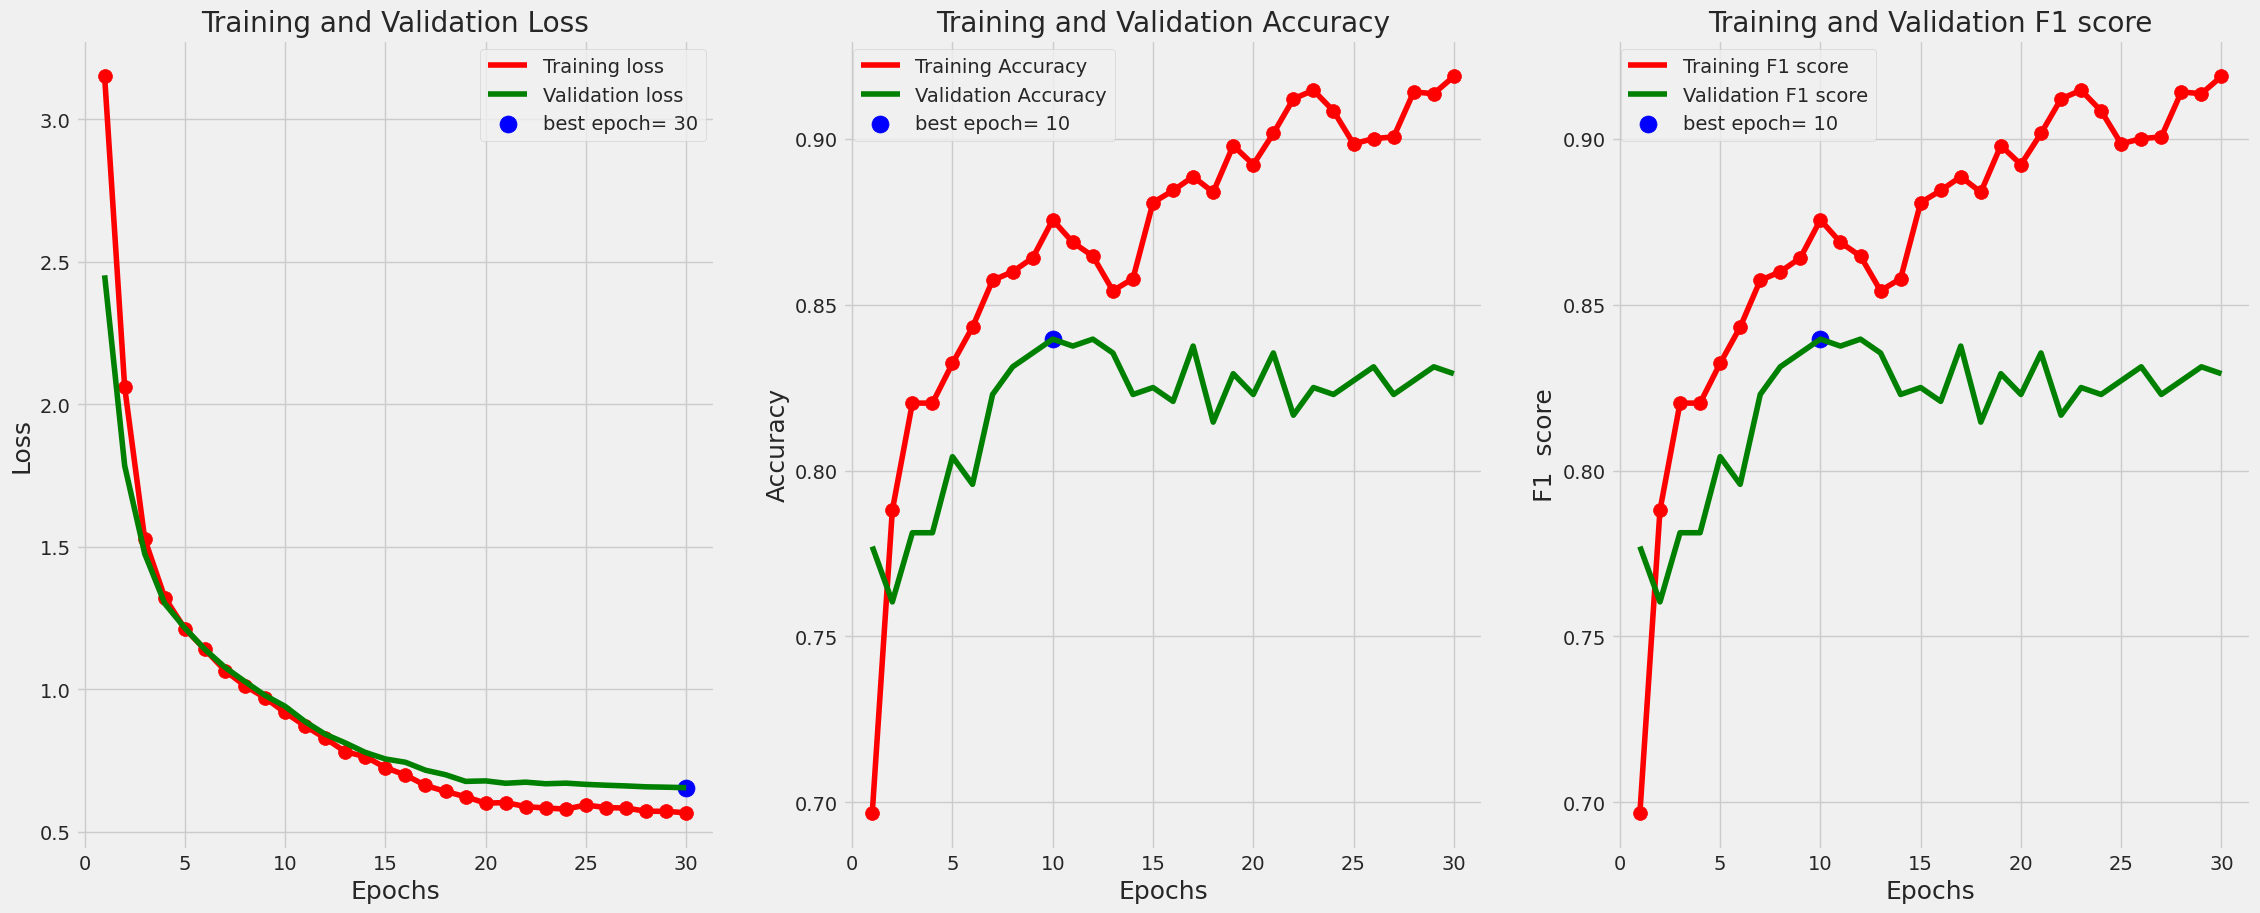

Enter a name to save training data as CSV (press enter to skip):


  ab_test


Training data saved to ./temp_outputs/ab_test.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
There were 71 errors in 600 tests for an accuracy of  88.17 and an F1 score of  88.17


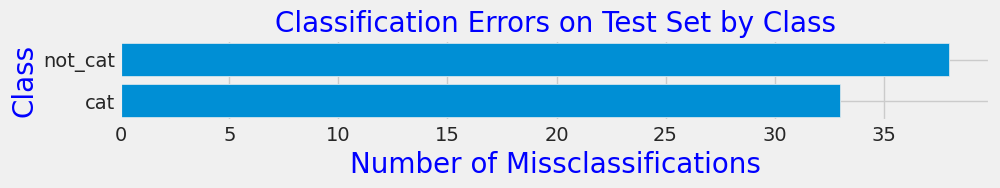

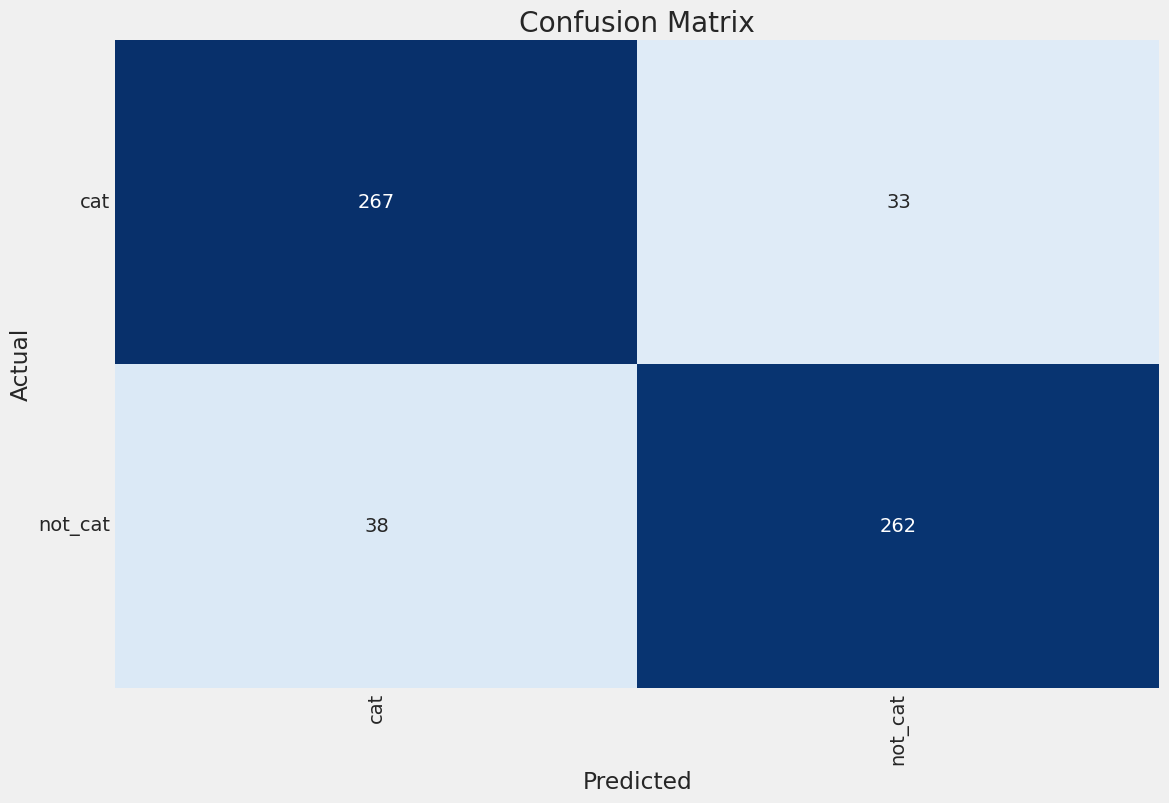

Classification Report:
----------------------
               precision    recall  f1-score   support

         cat     0.8754    0.8900    0.8826       300
     not_cat     0.8881    0.8733    0.8807       300

    accuracy                         0.8817       600
   macro avg     0.8818    0.8817    0.8817       600
weighted avg     0.8818    0.8817    0.8817       600

Trained model will be saved to ./temp_outputs. Enter a subject for the model:


  ab_test


Model saved successfully to: ./temp_outputs/ab_test-2-(96x96)-88.17.keras
Model saved as 'directory/subject-num_classes-(img_height,img_width)-F1score.keras'.
Enter "R" to rerun the classifier or press Enter to quit:


Process completed.


In [20]:
##### Run the classifier
working_dir, train_dir, test_dir, valid_dir = setup_and_train_model()

# Loop to allow re-running the classifier
rerun = True
while rerun:
    print_in_color('Enter "R" to rerun the classifier or press Enter to quit:')
    user_input = input(' ').strip().lower()
    
    if user_input == 'r':
        print_in_color('Press Enter to use the original directory values, or provide new ones:')
        use_original_dirs = input(' ').strip() == ''
        
        if use_original_dirs:
            # Rerun the classifier with previously used directory paths
            setup_and_train_model(
                working_dir=working_dir, 
                train_dir=train_dir, 
                test_dir=test_dir, 
                valid_dir=valid_dir, 
                interactive_mode=False
            )
        else:
            # Rerun with new directory paths
            setup_and_train_model(interactive_mode=True)
    else:
        rerun = False
        print_in_color('Process completed.')
